In [ ]:
# MetaNeighbor for pairs of datasets

In [3]:
library(SingleCellExperiment)
library(MetaNeighbor)
library(Seurat)
library(dplyr)

In [4]:
dirs = c('Govek', 'Hamed', 'La_Manno')
studies = dirs
length(dirs)

[1] 3

In [4]:
# get common genes
for(ii in 1:length(dirs)){
    sc1 = readRDS(paste0(dirs[ii], '/', studies[ii], '_A1N1N2.rds'))
    exp1 = LayerData(sc1, assay = 'RNA', layer = 'data') # cpm
    
    if(ii==1){
        common_genes = rownames(exp1)
    }else{
        common_genes = intersect(common_genes, rownames(exp1))
    }
}

length(common_genes)

[1] 2936

In [5]:
# save
write.table(common_genes, file = 'common_genes_N1N2.txt', sep = '\n', 
            row.names = F, col.names = F, quote = F)

In [5]:
# load shared genes
common_genes = unlist(read.delim('common_genes_N1N2.txt', sep = '\n', header = F))
names(common_genes) = NULL
head(common_genes)

[1] "Rgs20"  "St18"   "Sntg1"  "Adhfe1" "Prex2"  "Sulf1"

In [6]:
# get cpm matrices
exp_mat = c()
mtd = c()
pb = txtProgressBar(min = 0, max = length(dirs), initial = 0)

for(ii in 1:length(dirs)){  
    
    sc1 = readRDS(paste0(dirs[ii], '/', studies[ii], '_A1N1N2.rds'))
    exp1 = LayerData(sc1, assay = 'RNA', layer = 'data') # cpm
    colnames(exp1) = rownames(sc1@meta.data)
    sc1$study = studies[ii]

    keepids = which(sc1$celltype_N1N2!='none')
    mtd0 = sc1@meta.data[keepids, c('study', 'celltype_N1N2')]
    rownames(mtd0) = paste0(studies[ii], '_', colnames(exp1)[keepids])
    mtd = rbind(mtd, mtd0)
    
    exp2 = exp1[common_genes, keepids]
    colnames(exp2) = paste0(studies[ii], '_', colnames(exp1)[keepids])
    
    exp_mat = cbind(exp_mat, exp2)
    setTxtProgressBar(pb, ii)
}

In [7]:
# make SCE object
sce = SingleCellExperiment(list(counts = exp_mat), colData = DataFrame(mtd))
sce

class: SingleCellExperiment 
dim: 2936 79786 
metadata(0):
assays(1): counts
rownames(2936): Rgs20 St18 ... Nanos1 Csf2ra
rowData names(0):
colnames(79786): Govek_AAACCCAAGGCTCCCA_1_1_1_1
  Govek_AAACCCAAGTATAGGT_1_1_1_1 ...
  La_Manno_10X70_3_A_1:ACAGTGTGTGCTAGx
  La_Manno_10X68_4_A_1:ATAAGTTGCATTGGx
colData names(2): study celltype_N1N2
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [8]:
options(warn = -1)

# # defaults to top 95% of genes. May need to vary
# hvg = variableGenes(sce, exp_labels = sce$study)
# length(hvg)

hvg = common_genes

# get top 2k hvgs
if(length(hvg)>2000){
    hvg <- sample(hvg, 2000, replace = F)
}

In [9]:
# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$study, 
    cell_type = sce$celltype_N1N2, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$study, 
    cell_type = sce$celltype_N1N2, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

In [11]:
# save
save(aurocsall, aurocs1v1, file = 'N1N2_MN_aurocs.Rdata')

In [12]:
# plot heatmaps #
exps = sub('\\|.*', '', rownames(aurocsall))
ctypes = sub('.*\\|', '', rownames(aurocsall))

subs3 = c('Neurog2_positive', 'Neurog1_positive', 'double_positive')
subcol3 = c('#ffb403', '#1bd1f8', '#48bf91')

reg2 = studies
regcols2 = c('#579EA4', '#DF7713', '#F9C000')

cols1 = subcol3[match(ctypes, subs3)]  # for consensus
cols2 = regcols2[match(exps, reg2)]

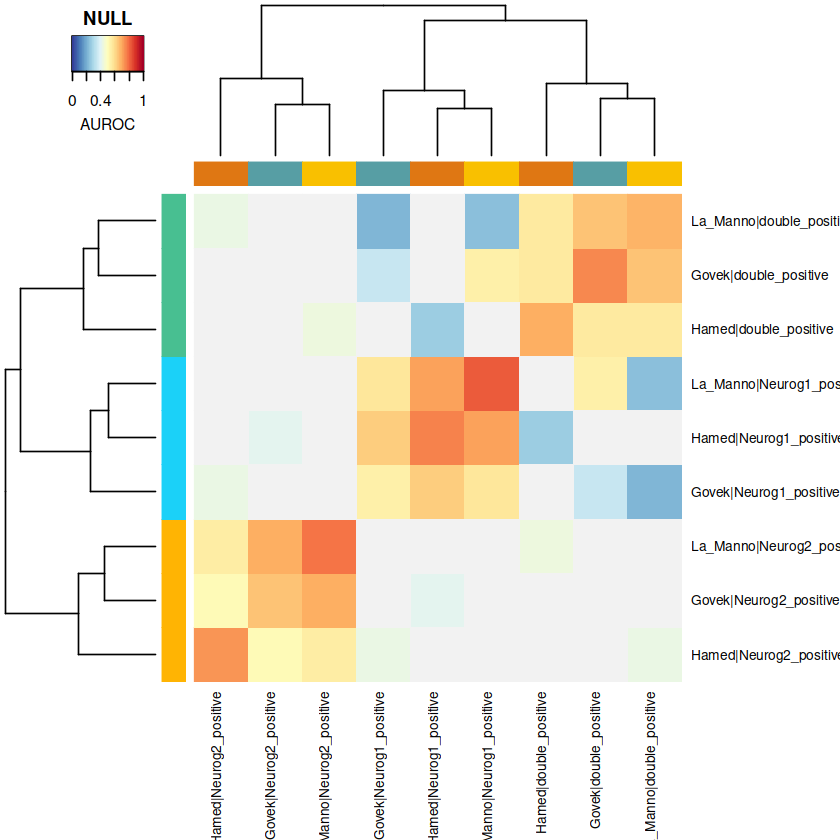

In [16]:
# png(paste0('aa_stacas_chicken_MN.png'), width = 15, height = 15, res = 300, units = 'in')
# pdf('aa-n1n2-mn-all-spe.pdf', width = 10, height = 10)
plotHeatmap(aurocs1v1, ColSideColors = cols2, RowSideColors = cols1, margins = c(10,10))
# dev.off()

In [10]:
topHits(aurocsall, dat = sce, study_id = sce$study,
        cell_type = sce$celltype_N1N2, threshold = 0.9)

Study_ID|Celltype_1    Study_ID|Celltype_2       Mean_AUROC
1 Govek|double_positive  La_Manno|double_positive  0.82      
2 Govek|Neurog2_positive La_Manno|Neurog2_positive 0.81      
  Match_type        
1 Reciprocal_top_hit
2 Reciprocal_top_hit

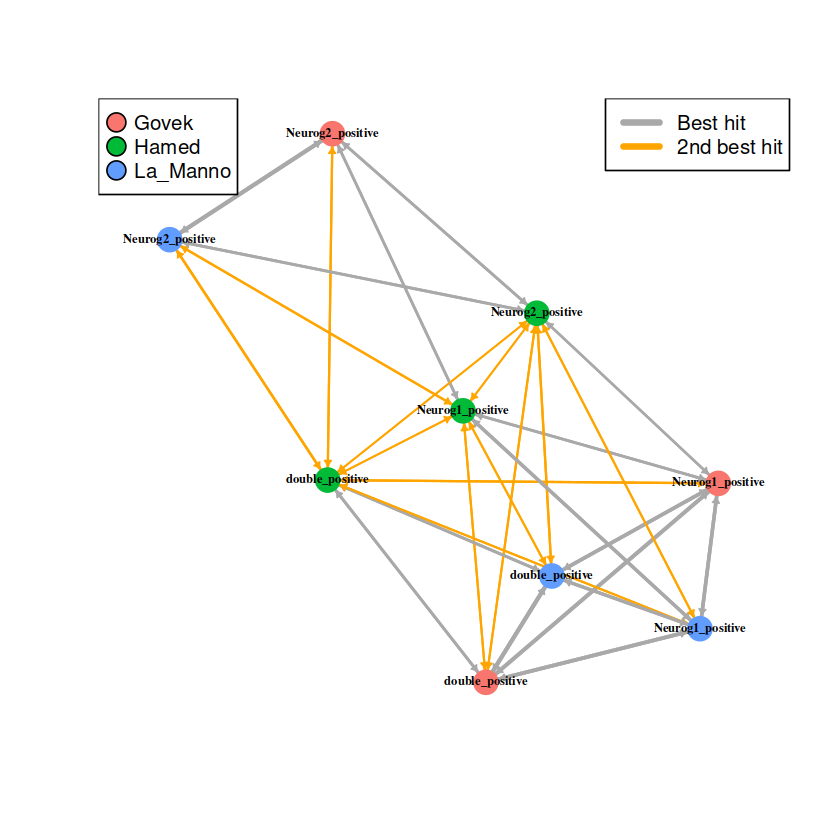

In [12]:
cluster_graph = makeClusterGraph(aurocsall, low_threshold = 0.3)
plotClusterGraph(cluster_graph, sce$study,
                 sce$celltype_N1N2, size_factor=3)

In [1]:
library(ggplot2)
library(ggbeeswarm)
load('N1N2_MN_aurocs.Rdata')

In [2]:
ctypes = c('double_positive', 'Neurog2_positive', 'Neurog1_positive')

In [3]:
combos = cbind(combn(ctypes,2), matrix(rep(ctypes,each=2), nrow = 2))
scoredf = data.frame(celltype1 = unlist(combos[1,]), celltype2 = unlist(combos[2,]),
                    auroc = NA)
scoredf2 = c()

for(ii in 1:dim(combos)[2]){
    c1 = combos[1,ii]
    c2 = combos[2,ii]
    
    id1 = grep(c1, rownames(aurocsall))
    id2 = grep(c2, rownames(aurocsall))

    mat = aurocsall[id1, id2]
    mat2 = mat[lower.tri(mat, diag = F)]
    scoredf$auroc[ii] = mean(mat2, na.rm = T)

    temp = data.frame(celltype1 = c1, celltype2 = c2, auroc = mat2)
    scoredf2 = rbind(scoredf2, temp)
}

scoredf$ctype = 'other'
scoredf$ctype[scoredf$celltype1==scoredf$celltype2] = 'identical'
scoredf

scoredf2$ctype = 'other'
scoredf2$ctype[scoredf2$celltype1==scoredf2$celltype2] = 'identical'

celltype1        celltype2        auroc     ctype    
1 double_positive  Neurog2_positive 0.3895625 other    
2 double_positive  Neurog1_positive 0.4752673 other    
3 Neurog2_positive Neurog1_positive 0.4035586 other    
4 double_positive  double_positive  0.6444685 identical
5 Neurog2_positive Neurog2_positive 0.6352841 identical
6 Neurog1_positive Neurog1_positive 0.7127802 identical

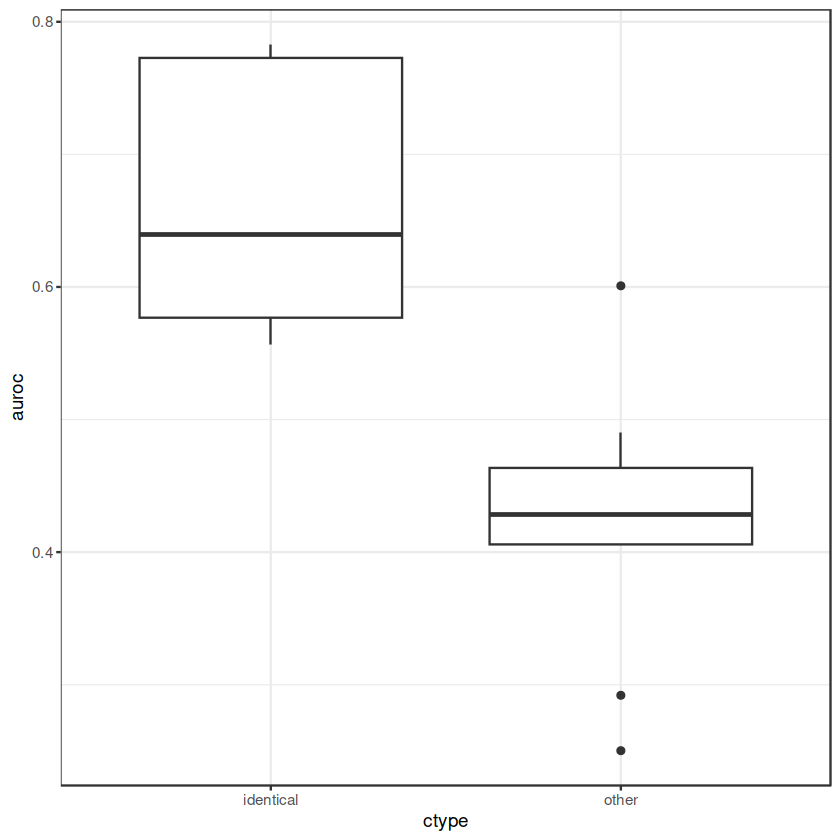

In [7]:
# pdf('aa-n1n2-beeswarm-mn.pdf', width = 4, height = 5)
ggplot(scoredf2, aes(ctype, auroc)) + geom_boxplot() + 
# geom_quasirandom(width=0.2) + 
theme_bw()
# dev.off()